In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Important functions

In [2]:
# Creating class of Linear Regression using PyTorch
class linear_regression_pytorch(nn.Module):
    def __init__(self,in_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim,1)
    def forward(self,x):
        return self.linear(x)

# Calculate R2 error given predicted and target values
def r_squared(y_pred,y_test):
    SS_tot = ((y_test - y_test.mean())**2).sum()
    SS_res = ((y_test - y_pred)**2).sum()
    return (1- SS_res/SS_tot)

# Calculate loss given predicted and target values
def evaluate_loss(y_pred,y_test):
    return (np.mean(((y_pred - y_test)**2)))**0.5

# Print the parameters of the PyTorch Linear Regression model
def print_parameters(model):
    for name, param in model.named_parameters():
        if name == 'linear.weight':
            print ('Weights:' + ': ' + str(param.data.numpy().squeeze()), end = '; ')
        if name == 'linear.bias':
            print ('Bias:' + ': ' + str(param.data.numpy().squeeze()), end = '; ')
    print()

# Train PyTorch Linear Regression Model
def train_model(x_train, y_train, no_epochs, learn_rate):
    no_features = x_train.shape[1]
    # Defining the model
    model = linear_regression_pytorch(no_features)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learn_rate)

    # Training the model
    loss_prev = 1000
    loss_all=[]
    for t in range(no_epochs):
        y_pred = model(x_train)
        loss = criterion(y_pred,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if np.abs(loss_prev-loss.item())<1e-13:
            break
            
        loss_prev=loss.item()    
        loss_all.append(loss.item())
        
        if t%5000==0 and t>0: # every 5000 iterations, displays the current iteration
            print(str(t) + ' epoch: ' + str(loss.item()**0.5) + '; ', end='')
            
    print('\nLoss on training set: ' + str(np.sqrt(loss.item())))
    
    plt.plot(loss_all)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    return model, loss.item()

# Plot the Linear Regression curve in the case of a single feature
def plot_regression(mu, std, start, stop, model, x, y):
    # Plotting the regression curve
    pom1 = (start - mu)/std
    pom2 = (stop  - mu)/std
    y_pred1 = model(torch.tensor(np.array([[pom1]]),dtype = torch.float32))
    y_pred2 = model(torch.tensor(np.array([[pom2]]),dtype = torch.float32))
    plt.scatter(x*std+mu, y)
    plt.plot([start,stop],[y_pred1.data.numpy()[0],y_pred2.data.numpy()[0]])
    plt.xlabel('Square feet of living area')
    plt.ylabel('Price')
    plt.show()
    
# Normalize data
def normalize_data(input_data):
    mu = input_data.mean(axis=0)
    std = input_data.std(axis=0)
    return (input_data-mu)/std, mu, std

In [3]:
# Import data
data = pd.read_csv("kc_house_data.csv")

# Feature names
print(data.columns)

# Show first 5 examples
data.head(5)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Linear Regression using single feature: Square feet living area


Loss on training set: 261517.25076560437


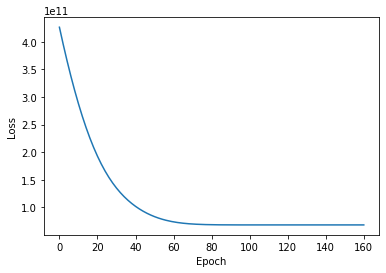

Loss on test set: 260770.47194803326
R_squared error on test set: 0.4853394627571106
Weights:: 258263.55; Bias:: 539663.0; 


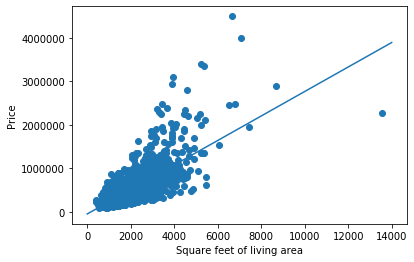

In [4]:
# Preparing data
x1 = torch.tensor(data['sqft_living'].values).float().view(-1,1) # square feet living area
y1 = torch.tensor(data['price'].values).float().view(-1,1) # prices
x_train1_not_normalized , x_test1_not_normalized , y_train1 , y_test1 = train_test_split(x1 , y1 , test_size = 0.10, random_state = 15)
x_train1, mu1, std1 = normalize_data(x_train1_not_normalized) # Normalizing training data
x_test1 = (x_test1_not_normalized- mu1)/std1 # Normalizing test data

# Training model
model1, loss1 = train_model(x_train1, y_train1, 10000, 10000)
y_pred1 = model1(x_test1)

# Results
print('Loss on test set: '    +     str( evaluate_loss(y_pred1.data.numpy(), y_test1.data.numpy()) ) )
print('R_squared error on test set: ' + str( r_squared(y_pred1.data.numpy(), y_test1.data.numpy()) ) )
print_parameters(model1)
plot_regression(mu1, std1, 0, 14000, model1, x_test1, y_test1)

# Linear Regression using multiple features

5000 epoch: 540098.2106839459; 10000 epoch: 486322.1158697186; 15000 epoch: 441334.7748455814; 20000 epoch: 398620.77224349463; 25000 epoch: 357623.0779130452; 30000 epoch: 318941.8280251118; 35000 epoch: 283463.8102333347; 40000 epoch: 252450.1072291315; 45000 epoch: 227559.17074906034; 50000 epoch: 210628.64777612756; 55000 epoch: 202784.48224654666; 
Loss on training set: 201786.1033074379


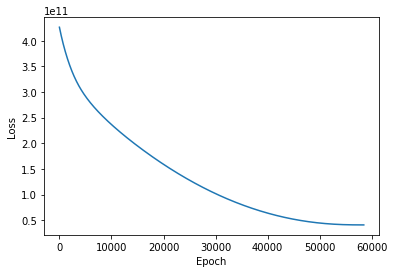

Loss on test set: 195777.71558581432
R_squared error on test set: 0.7099114656448364
Weights:: [-33682.062   33312.902   77346.24     5589.2256   3274.7249  48456.684
  41412.555   17128.285  111498.04    82648.47    29019.266  -77391.734
   8035.921  -31454.236   83795.055  -30621.064   13131.566  -10328.622 ]; Bias:: 537564.25; 


In [5]:
# Preparing data (all features)
x2 = torch.tensor(data.drop(['id','price','date'],axis=1).values).float()
y2 = torch.tensor(data['price'].values).float().view(-1,1)
x_train2_not_normalized , x_test2_not_normalized , y_train2 , y_test2 = train_test_split(x2 , y2 , test_size = 0.10, random_state = 15)
x_train2, mu2, std2 = normalize_data(x_train2_not_normalized) # Normalizing training data
x_test2 = (x_test2_not_normalized- mu2)/std2 # Normalizing test data

# Training model
model2, loss2 = train_model(x_train2, y_train2, no_epochs = 100000, learn_rate = 10)
y_pred2 = model2(x_test2)

print('Loss on test set: '    +     str( evaluate_loss(y_pred2.data.numpy(), y_test2.data.numpy()) ) )
print('R_squared error on test set: ' + str( r_squared(y_pred2.data.numpy(), y_test2.data.numpy()) ) )
print_parameters(model2)

# Linear Regression using sklearn 

In [6]:
# Linear Regression using single feature: Square feet living area
lin_reg_sklearn1 = LinearRegression()
lin_reg_sklearn1.fit(x_train1,y_train1)

print('Single feature Linear Regression:')
print(' -R_squared error on test set: ' + str( lin_reg_sklearn1.score(x_test1,y_test1)) )
print(' -Weight: ' + str( lin_reg_sklearn1.coef_.squeeze()) )
print(' -Bias: ' + str( lin_reg_sklearn1.intercept_.squeeze()) )

# Linear Regression using multiple features
lin_reg_sklearn2 = LinearRegression()
lin_reg_sklearn2.fit(x_train2,y_train2)

print('\nMultiple features Linear Regression:')
print(' -R_squared error on test set: ' + str( lin_reg_sklearn2.score(x_test2,y_test2)) )
print(' -Weights: ' + str( lin_reg_sklearn2.coef_.squeeze()) )
print(' -Bias: ' + str( lin_reg_sklearn2.intercept_.squeeze()) )

Single feature Linear Regression:
 -R_squared error on test set: 0.4853441220958904
 -Weight: 258226.34
 -Bias: 539665.3

Multiple features Linear Regression:
 -R_squared error on test set: 0.7099235735371086
 -Weights: [-33682.047   33313.227   82804.53     5589.2803   3274.7754  48456.797
  41412.67    17128.219  111498.06    77728.39    26383.008  -77391.664
   8035.968  -31454.762   83795.14   -30621.371   13131.598  -10328.544 ]
 -Bias: 539672.0


# Normal Equations

In [7]:
def add_intercept_term(X):
    return np.append( np.ones((X.shape[0],1)),X.data.numpy(),axis=1 )

def normal_equations(X,Y):
    X_i = add_intercept_term(X)
    W = np.linalg.inv( X_i.T.dot(X_i) ).dot( X_i.T.dot(Y.data.numpy()))
    return W

def evaluate_normal_equations(W,X):
    X_i = add_intercept_term(X)
    return X_i.dot(W)

In [8]:
# Linear Regression using single feature: Square feet living area
W1 = normal_equations(x_train1,y_train1)
y_pred_normal1 = evaluate_normal_equations(W1,x_test1)

print('Single feature Linear Regression:')
print(' -Loss on test set: '    +     str( evaluate_loss(y_pred_normal1, y_test1.data.numpy()) ) )
print(' -R_squared error on test set: ' + str( r_squared(y_pred_normal1, y_test1.data.numpy()) ) )
print(' -Weights: ' + str( W1[1:].squeeze()) )
print(' -Bias: ' + str( W1[0].squeeze()) )

# Linear Regression using multiple features
W2 = normal_equations(x_train2,y_train2)
y_pred_normal2 = evaluate_normal_equations(W2,x_test2)

print('\nMultiple features Linear Regression:')
print(' -Loss on test set: '    +     str( evaluate_loss(y_pred_normal2, y_test2.data.numpy()) ) )
print(' -R_squared error on test set: ' + str( r_squared(y_pred_normal2, y_test2.data.numpy()) ) )
print(' -Weights: ' + str( W2[1:].squeeze()) )
print(' -Bias: ' + str( W2[0].squeeze()) )

Single feature Linear Regression:
 -Loss on test set: 260769.29435737635
 -R_squared error on test set: 0.48534412136400806
 -Weights: 258226.2994686544
 -Bias: 539665.315829494

Multiple features Linear Regression:
 -Loss on test set: 197009.23309587126
 -R_squared error on test set: 0.7062504600680063
 -Weights: [-3.18474694e+04  2.76591503e+04 -5.67074636e+11  4.96131516e+03
  1.60119250e+03  4.73996546e+04  4.23932634e+04  1.80682692e+04
  1.08421687e+05  5.11147262e+11  2.73876443e+11 -7.68374726e+04
  8.37491614e+03 -3.13856699e+04  8.38821774e+04 -3.03867704e+04
  1.57844208e+04 -1.05521956e+04]
 -Bias: 522815.685546875
